In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
import os 

In [7]:
df = yf.download("BAC", start="2020-03-01", end="2021-03-01")

[*********************100%***********************]  1 of 1 completed


In [8]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02,28.350000,29.379999,27.440001,29.370001,28.461542,147776300
2020-03-03,29.370001,29.750000,27.620001,27.750000,26.891647,138698500
2020-03-04,28.250000,28.420000,27.400000,28.389999,27.511854,111239800
2020-03-05,27.240000,27.350000,26.400000,26.780001,26.117243,110878700
2020-03-06,25.469999,26.209999,25.100000,25.709999,25.073723,119121200


In [9]:
df['Adj Close'].head()

Date
2020-03-02    28.461542
2020-03-03    26.891647
2020-03-04    27.511854
2020-03-05    26.117243
2020-03-06    25.073723
Name: Adj Close, dtype: float64

In [10]:
da = df['Adj Close']
da.describe().round(2)

count    251.00
mean      25.70
std        3.75
min       17.63
25%       23.29
50%       24.65
75%       28.23
max       36.20
Name: Adj Close, dtype: float64

In [11]:
da.head()

Date
2020-03-02    28.461542
2020-03-03    26.891647
2020-03-04    27.511854
2020-03-05    26.117243
2020-03-06    25.073723
Name: Adj Close, dtype: float64

Text(0.5, 1.0, 'Adj Close')

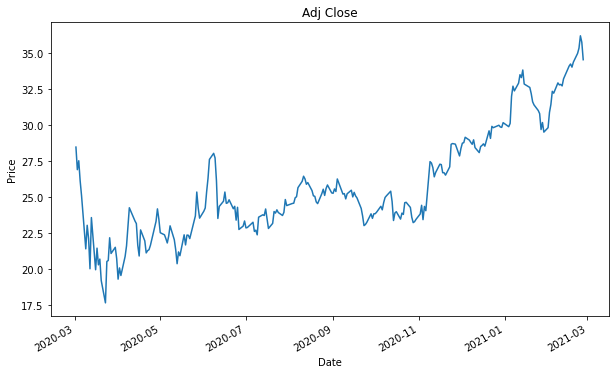

In [12]:
da.plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Adj Close')


In [13]:
da.diff().head().round(2)

Date
2020-03-02     NaN
2020-03-03   -1.57
2020-03-04    0.62
2020-03-05   -1.39
2020-03-06   -1.04
Name: Adj Close, dtype: float64

In [14]:
da.pct_change().round(4).head()

Date
2020-03-02       NaN
2020-03-03   -0.0552
2020-03-04    0.0231
2020-03-05   -0.0507
2020-03-06   -0.0400
Name: Adj Close, dtype: float64

In [15]:
logda = np.log(da / da.shift(1))
logda.head().round(4)

Date
2020-03-02       NaN
2020-03-03   -0.0567
2020-03-04    0.0228
2020-03-05   -0.0520
2020-03-06   -0.0408
Name: Adj Close, dtype: float64

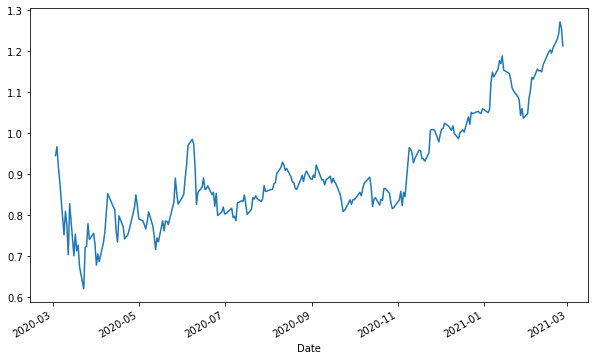

In [16]:
 logda.cumsum().apply(np.exp).plot(figsize=(10, 6));

In [17]:
nr = logda.mean() * 252
yvol = logda.std() * (252 ** 0.5)
print('The one year annulized volatility is %.8f' % (yvol))

The one year annulized volatility is 0.58882265


In [18]:
sixlr = logda[126:-1]


In [19]:
snr = sixlr.mean() * 252
svol = sixlr.std() * (252 ** 0.5)
print('The six months annulized volatility is %.8f' % (svol))

The six months annulized volatility is 0.35799659


In [20]:
#average volatility used
vol= (yvol+svol)/2
print('The final annulized volatility is %.8f' % (vol))

The final annulized volatility is 0.47340962


In [21]:
#MONTE CARLOS

In [28]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [29]:
T = 4/52
r = 0.0162
sigma = 0.4734
S0 = 36.9
K = 39.0

In [30]:
S = mcs_simulation_np(1000)

In [31]:
S = np.transpose(S)
S

array([[36.9       , 37.09242144, 36.7491677 , ..., 58.06480038,
        57.7395495 , 57.45496961],
       [36.9       , 37.01953239, 36.86188435, ..., 36.04314333,
        36.14322176, 36.16031082],
       [36.9       , 37.01414484, 37.12625233, ..., 35.92252469,
        35.8437026 , 35.71545183],
       ...,
       [36.9       , 36.94374571, 37.00911742, ..., 32.99886378,
        32.67275817, 32.4612926 ],
       [36.9       , 36.9856757 , 36.74768804, ..., 29.13635647,
        29.28340191, 29.13169017],
       [36.9       , 36.88708297, 37.02283549, ..., 40.77585875,
        41.07827789, 41.34330867]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

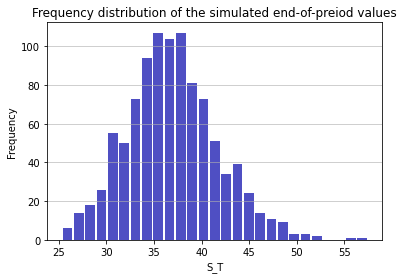

In [32]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [33]:
pp = (K - S[-1,:])>0
bpp = np.mean(np.maximum(pp.astype(int),0))
print('Binary put', str(bpp))

Binary put 0.5644355644355644


In [202]:
#BlackScholes Model 2 

In [34]:
def binary_option_bsm(S, K, T, r, q, vol, payoff):
    
    #Sa: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [35]:
binary_option_bsm(36.9,39,4/52,0.0162,0,0.4734,'put')


0.6827239468314936

In [36]:
S = np.linspace(10,70,11)
pp = np.zeros((len(S),1))
for i in range(len(S)):
    pp[i] = binary_option_bsm(S[i],39,4/52,0.0162,0,0.4734,'put')

In [37]:
pp

array([[9.98754622e-01],
       [9.98754622e-01],
       [9.98749616e-01],
       [9.93818893e-01],
       [8.63501299e-01],
       [4.45090806e-01],
       [1.14705922e-01],
       [1.63636893e-02],
       [1.50366011e-03],
       [1.00933485e-04],
       [5.43413114e-06]])

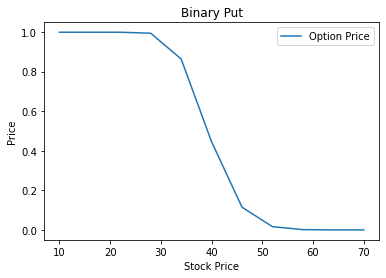

In [38]:
fig = plt.figure()
plt.plot(S, pp, '-')
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('Binary Put')
plt.legend(['Option Price','Payoff at T'])

In [39]:
#GREEKS

In [40]:
#DELTA

In [210]:
def delta(S,k,T,r,q,vol,payoff):
    d1 = (np.log(S/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    
    if payoff == 'call':
        delta =  (np.exp(-r*T))*si.norm.pdf(d2,0.0,1.0)/(vol*S*np.sqrt(T))
    elif payoff == 'put':
        delta = -(np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))/(vol*S*np.sqrt(T))

    return delta

In [211]:
delta(36.9,39,4/52,0.0162,0,0.4734,'put')

-0.07337183106362687

In [212]:
S = np.linspace(10, 70, 51)
T = np.linspace(0.02, 2, 51)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 39, T[i], 0.0162,0,0.4734,'put')

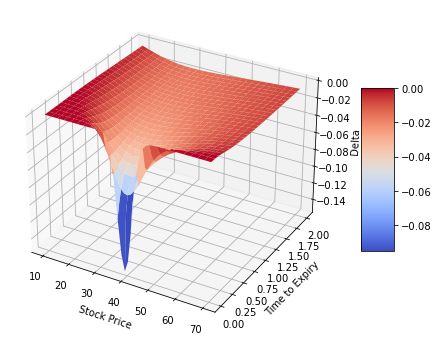

In [213]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [214]:
#GAMMA

In [215]:
def gamma(S,k,T,r,q,vol,payoff):
    d1 = (np.log(S/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    
    if payoff == 'call':
        gamma = (np.exp(-r*T)*d1*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S**2)*(T))
    elif payoff == 'put':
        gamma = -(np.exp(-r*T)*d1*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S**2)*(T))

    return gamma

In [216]:
gamma(36.9,39,4/52,0.0162,0,0.4734,'put')

0.005246292430089717

In [217]:
S = np.linspace(10, 70, 51)
T = np.linspace(0.02, 2, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 39, T[i], 0.0162,0,0.4734,'put')

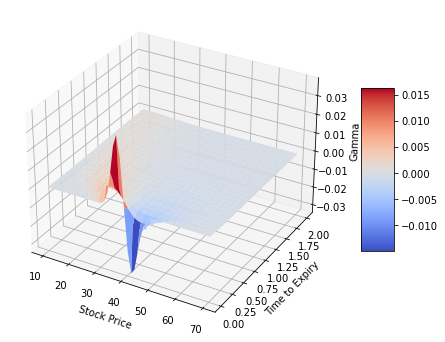

In [218]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [219]:
#THETA

In [220]:
def theta(S0,k,T,r,q,vol,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    a = d1/(2*T)
    b = (r-q)/(vol*np.sqrt(T))
    if payoff == 'call':
        theta = (r* np.exp(-r*T)*(si.norm.cdf(d2,0.0,1.0)))+(np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))* (a-b)
    elif payoff == 'put':
        theta = (r* np.exp(-r*T)*(1- si.norm.cdf(d2,0.0,1.0)))-(np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))* (a-b)

    return theta

In [221]:
theta(36.9,39,4/52,0.0162,0.0,0.4734,'put')

0.8553657877939422

In [222]:
S = np.linspace(10, 70, 51)
T = np.linspace(0.02, 2, 51)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 39, T[i], 0.0162,0.0,0.4734,'put')

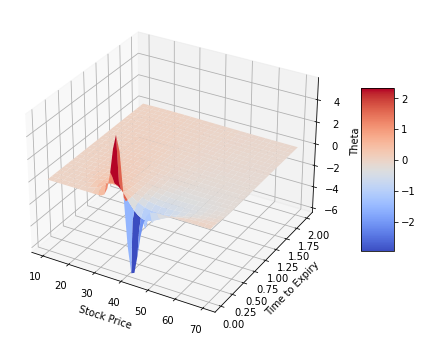

In [223]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [224]:
#SPEED

In [225]:
def speed(S0,k,T,r,q,vol,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * vol **2)*T)/(vol * np.sqrt(T))
    a= (np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0))/((vol**2)*(S0**3)*(T))
    b= ((-2*d1)+((1-(d1*d2))/(vol*np.sqrt(T))))
    
    if payoff == 'call':
        speed = -a*b
    elif payoff == 'put':
        speed = a*b

    return speed

In [226]:
speed(36.9,39,4/52,0.0162,0,0.4734,'put')

0.0028928677065502206

In [227]:
S = np.linspace(10, 70, 51)
T = np.linspace(0.02, 2, 51)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 39, T[i], 0.0162,0,0.4734,'put')

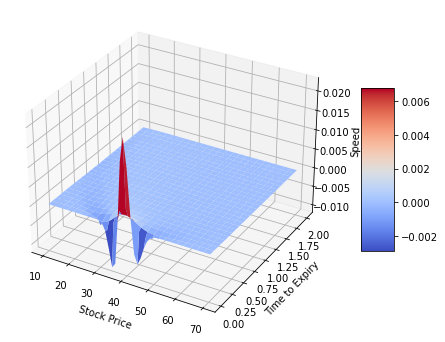

In [228]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [229]:
#VEGA

In [230]:
def vega(S0,k,T,r,q,sig,payoff):
    d1 = (np.log(S0/k) + (r + 0.5 * sig **2)*T)/(sig * np.sqrt(T))
    d2 = (np.log(S0/k) + (r - 0.5 * sig **2)*T)/(sig * np.sqrt(T))
    a = (np.sqrt(T) + ((d2)/sig))   
    if payoff == 'call':
        vega = (-np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0)) * a
    elif payoff == 'put':
        vega = (np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0)) * a
            
    return vega

In [231]:
vega(36.9,39,4/52,0.0162,0,0.4734,'put')

-0.26012981270743796

In [237]:
S = np.linspace(10, 70, 51)
T = np.linspace(0.02, 2, 51)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 39, T[i], 0.0162,0,0.4734,'put')

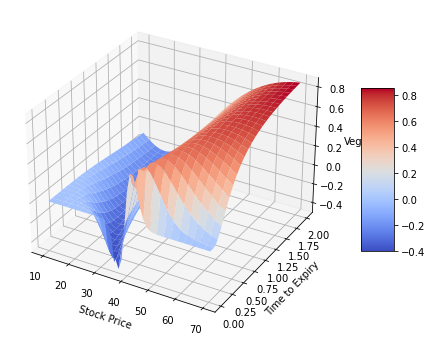

In [238]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);